## Fluff Analysis

In [29]:
# Imports
import sys
import matplotlib.pyplot as plt

if 'pandas' not in sys.modules: import pandas as pd
# if 'numpy' not in sys.modules: import numpy as np
# if 'matplotlib.pyplot' not in sys.modules: import matplotlib.pyplot as plt

# if 'sklearn.metrics' not in sys.modules: from sklearn.metrics import cohen_kappa_score
# if 'scipy.stats' not in sys.modules: from scipy.stats import spearmanr
# if 'pingouin' not in sys.modules: import pingouin as pg


In [30]:
# read in text data --> text_data
text_data = pd.read_csv('Inputs/texts.csv')

# subset for testing
# text_data = text_data.iloc[:4]

### Human Evaluations

In [31]:
# read in raw qualtrics data --> data_raw
data_raw = pd.read_csv('Inputs/Qualtrics_Export.csv').drop([0, 1]).reset_index(drop=True)
drop_columns = ['StartDate', 'EndDate', 'Status', 'IPAddress', 'Progress', 'Duration (in seconds)', 'Finished', 'RecipientLastName', 'RecipientFirstName', 'RecipientEmail', 'ExternalReference', 'LocationLatitude', 'LocationLongitude', 'DistributionChannel', 'UserLanguage', 'Q_AmbiguousTextPresent', 'Q_AmbiguousTextQuestions', 'Q_StraightliningCount', 'Q_StraightliningPercentage', 'Q_StraightliningQuestions', 'Q_UnansweredPercentage', 'Q_UnansweredQuestions']
data_raw = data_raw.drop(columns=drop_columns)

#### Fluff Scores

In [32]:
# extract Fluff Scores and clean --> fluff_scores_human
fluff_scores_human = data_raw.filter(regex='\.3$|Q2.1') # extract all third Subquestions which are the human fluff scores
question_nr = [int(x[1:-2]) for x in list(fluff_scores_human.columns[1:])] # extract the question block numbers
text_nr = ['T' + str(x-2) for x in question_nr] # create the corresponding text numbers
fluff_scores_human.columns = ['Expert'] + text_nr # rename columns
fluff_scores_human = fluff_scores_human.apply(pd.to_numeric, errors='coerce') # convert to numeric
fluff_scores_human['Expert'] = fluff_scores_human['Expert'].replace({1: False, 2: True}).astype(bool) # convert to boolean

/var/folders/gq/nyrwnfys5j3dprx6sm_bcrjc0000gn/T/ipykernel_51034/4282660814.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  fluff_scores_human['Expert'] = fluff_scores_human['Expert'].replace({1: False, 2: True}).astype(bool) # convert to boolean


In [33]:
# descriptive statistics for student and expert fluff scores --> fluff_scores_summary_students, fluff_scores_summary_experts
fluff_scores_summary_students = fluff_scores_human.where(fluff_scores_human['Expert'] == False).describe().transpose()[['mean', 'std', 'count']].round(2)
fluff_scores_summary_experts = fluff_scores_human.where(fluff_scores_human['Expert'] == True).describe().transpose()[['mean', 'std', 'count']].round(2)
# fluff_scores_summary_humans = fluff_scores_human.drop(columns=['Expert']).describe().transpose()[['mean', 'std', 'count']].round(2)

In [34]:
# Add human fluff scores to text_data
text_data = text_data.merge(fluff_scores_summary_experts[['mean']], left_on='T', right_index=True, how='left').rename(columns={'mean': 'Expert Score'})
text_data = text_data.merge(fluff_scores_summary_students[['mean']].round(0), left_on='T', right_index=True, how='left').rename(columns={'mean': 'Student Score'})

#### Fluff Characacteristic Ratings

### LLM Evaluations

In [35]:
# Imports
if 'fluff_finder' not in sys.modules: from fluff_finder import VanillaFluffEvaluator, client

Vanilla Evaluations

In [36]:
# evaluate text data with VanillaFluffEvaluator --> add Vanilla Score and Vanilla Reason to text_data
vanilla_evaluator = VanillaFluffEvaluator(client) # create VanillaFluffEvaluator object

vanilla_scores = text_data['Text'].apply(vanilla_evaluator.evaluate) # evaluate text data
vanilla_scores = pd.DataFrame(vanilla_scores.tolist(), columns=['Vanilla Score', 'Vanilla Reason']) # convert to DataFrame
text_data = pd.concat([text_data, vanilla_scores], axis=1) # merge with text data

### Score Correlation Analysis

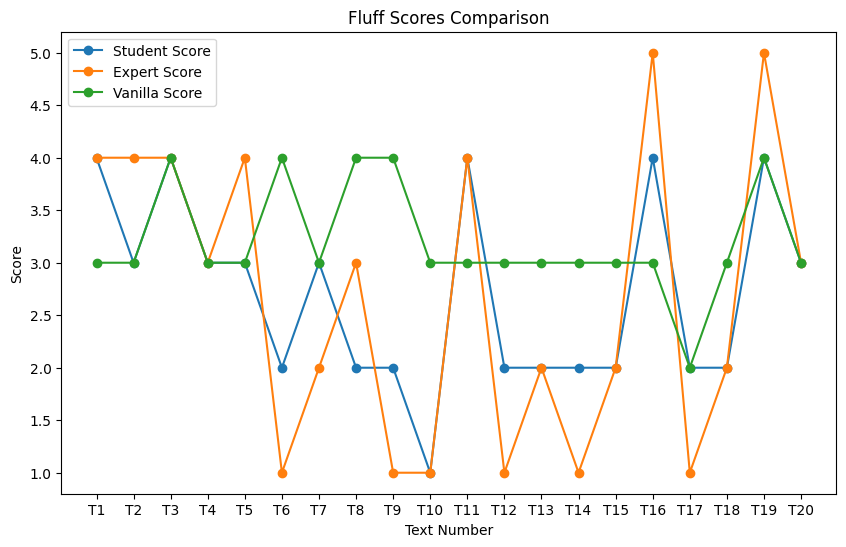

In [37]:
# visualize the scores
# Create a single set of axes
fig, ax = plt.subplots(figsize=(10, 6))

# Plot each score series as a line
text_data['Student Score'].plot(kind='line', ax=ax, label='Student Score', marker='o')
text_data['Expert Score'].plot(kind='line', ax=ax, label='Expert Score', marker='o')
text_data['Vanilla Score'].plot(kind='line', ax=ax, label='Vanilla Score', marker='o')

# Add title and labels
ax.set_title('Fluff Scores Comparison')
ax.set_xlabel('Text Number') 
ax.set_ylabel('Score')

# Ensure x-axis shows values from the T column
ax.set_xticks(range(len(text_data['T'])))
ax.set_xticklabels(text_data['T'])

# Add a legend to differentiate the lines
ax.legend()

# Show the plot
plt.show()


In [39]:
# Score agreements using Cohen's Kappa
from sklearn.metrics import cohen_kappa_score

# calculate Cohen's Kappa between student and expert fluff scores
kappa_se = cohen_kappa_score(text_data['Student Score'], text_data['Expert Score'])
print(f'Cohen\'s Kappa between Student and Expert Scores: {kappa_se:.2f}')

# calculate Cohen's Kappa between student and Vanilla fluff scores
kappa_sv = cohen_kappa_score(text_data['Student Score'], text_data['Vanilla Score'])
print(f'Cohen\'s Kappa between Student and Vanilla Scores: {kappa_sv:.2f}')

# calculate Cohen's Kappa between expert and Vanilla fluff scores
kappa_ev = cohen_kappa_score(text_data['Expert Score'], text_data['Vanilla Score'])
print(f'Cohen\'s Kappa between Expert and Vanilla Scores: {kappa_ev:.2f}')



Cohen's Kappa between Student and Expert Scores: 0.31
Cohen's Kappa between Student and Vanilla Scores: 0.19
Cohen's Kappa between Expert and Vanilla Scores: -0.03


In [42]:
# score agreements using Spearman's Rank Correlation
from scipy.stats import spearmanr

# calculate Spearman's Rank Correlation between student and expert fluff scores
spearman_se = spearmanr(text_data['Student Score'], text_data['Expert Score'])
print(f'Spearman\'s Rank Correlation between Student and Expert Scores: {spearman_se.correlation:.2f} with p-value: {spearman_se.pvalue:.2f}')

# calculate Spearman's Rank Correlation between student and Vanilla fluff scores
spearman_sv = spearmanr(text_data['Student Score'], text_data['Vanilla Score'])
print(f'Spearman\'s Rank Correlation between Student and Vanilla Scores: {spearman_sv.correlation:.2f} with p-value: {spearman_sv.pvalue:.2f}')

# calculate Spearman's Rank Correlation between expert and Vanilla fluff scores
spearman_ev = spearmanr(text_data['Expert Score'], text_data['Vanilla Score'])
print(f'Spearman\'s Rank Correlation between Expert and Vanilla Scores: {spearman_ev.correlation:.2f} with p-value: {spearman_ev.pvalue:.2f}')

Spearman's Rank Correlation between Student and Expert Scores: 0.88 with p-value: 0.00
Spearman's Rank Correlation between Student and Vanilla Scores: 0.10 with p-value: 0.69
Spearman's Rank Correlation between Expert and Vanilla Scores: 0.14 with p-value: 0.56
